In [1]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import root_mean_squared_error
import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# Prepare a directory to save models
model_dir = 'model_checkpoints_kfold_only_cgm'
os.makedirs(model_dir, exist_ok=True)

# Load processed data
training_filename = "./processed_data/BIG_training_data_onlyCGM.pkl"
input_size = 2
ph = 6 
history = 6


In [24]:
def prepare_dataset(segments, ph, history, input_size):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        if input_size == 4: 
            segment_df['carb_effect'] = pd.to_numeric(segment_df['carb_effect'], errors='coerce')
            segment_df['steps'] = pd.to_numeric(segment_df['steps'], errors='coerce')
            segment_df['steps'] = segment_df['steps'] 
            
        segment_df['bolus_effect'] = pd.to_numeric(segment_df['bolus_effect'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        max_index = len(segment_df) - (history-1+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + history-1 to exist
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index + 1):
            # Extracting features from index i to i+history-1
            if input_size == 4:
                features = segment_df.loc[i:i+history-1, ['glucose_value',  'bolus_effect', 'carb_effect', 'steps']] 
            else: 
                features = segment_df.loc[i:i+history-1, ['glucose_value',  'bolus_effect']]
            
            label = segment_df.loc[i+history-1+ph, 'glucose_value'] - segment_df.loc[i+history-1, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history-1+ph, 'glucose_value'])
            features_list.append(features)
            labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    print("len of labels_list " + str(len(labels_list)))
    # new_labels_list = label_delta_transform(labels_list)    
    # print("after label transform. the len of label list "+str(len(new_labels_list)))    
    return features_list, labels_list, raw_glu_list

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim


class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(StackedLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob).to(device)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 512).to(device)
        self.fc2 = nn.Linear(512, 128).to(device)
        self.fc3 = nn.Linear(128, output_size).to(device)
        
        # Activation functions
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size from the input tensor

        # Initialize hidden and cell state for the first LSTM layer
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # First LSTM layer
        out, (hn, cn) = self.lstm1(x, (h0, c0))
        
        # Dropout layer
        out = self.dropout(out)
        
        # Initialize hidden and cell state for the second LSTM layer
        h1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # Second LSTM layer
        out, (hn, cn) = self.lstm2(out, (h1, c1))
        
        # Fully connected layers
        out = out[:, -1, :]  # Get the last time step output
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out


In [26]:

# Load the dictionary from the file
with open(training_filename, 'rb') as f:
    loaded_df_dict = pickle.load(f)

print(loaded_df_dict['1segment_1'])
print(loaded_df_dict['1segment_2'])

step_updated_segments = loaded_df_dict


             timestamp  glucose_value  bolus_effect
0  2021-12-07 16:30:00            101          0.58
1  2021-12-07 16:35:00            100          0.51
2  2021-12-07 16:40:00            100          0.44
3  2021-12-07 16:45:00             99          0.37
4  2021-12-07 16:50:00             98          0.30
..                 ...            ...           ...
65 2021-12-07 21:55:00            144          1.13
66 2021-12-07 22:00:00            140          1.06
67 2021-12-07 22:05:00            139          0.99
68 2021-12-07 22:10:00            140          0.92
69 2021-12-07 22:15:00            140          0.70

[70 rows x 3 columns]
               timestamp  glucose_value  bolus_effect
0    2021-12-07 22:35:00            139          0.57
1    2021-12-07 22:40:00            143          0.50
2    2021-12-07 22:45:00            138          0.43
3    2021-12-07 22:50:00            133          0.36
4    2021-12-07 22:55:00            132          0.29
...                  ...     

In [31]:
# Prepare for training
features_list, labels_list, raw_glu_list = prepare_dataset(step_updated_segments, ph, history, input_size) # segments, ph, history

# Build training and validation loader
features_array = np.array(features_list)
labels_array = np.array(raw_glu_list) # Maybe need to replace this

print("Prediction horizon: ", ph)
print("History: ", history)

len of features_list 67203
len of labels_list 67203
Prediction horizon:  6
History:  6


In [38]:
features_array.shape

(67203, 6, 2)

In [39]:
labels_array.shape

(67203,)

In [40]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.optim as optim
import os

# Assuming your StackedLSTM model class is defined elsewhere
input_size = input_size
hidden_size = 128
num_layers = 2
output_size = 1
dropout_prob = 0.2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming X, y are your complete dataset arrays
# X = torch.tensor(features_array, dtype=torch.float32).to(device)
# y = torch.tensor(labels_array, dtype=torch.float32).to(device)
# Set up K-Fold Cross Validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=False)
num_epochs = 50

for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    print(f'Fold {fold + 1}/{num_folds}')
    
    # Sample data for this fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Create Datasets and Loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize model, criterion, and optimizer for each fold
    model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
         # Forward pass
    
    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Reshape targets to match output shape
            targets = targets.view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')
            
        model.eval()
        with torch.no_grad():
            total_loss = 0
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.float())
                total_loss += loss.item()
            
            avg_loss = total_loss / len(val_loader)
            print(f'Test Loss: {avg_loss:.4f}')
            
    fold_path = os.path.join(model_dir, f'model_fold_{fold + 1}.pth')
    torch.save(model.state_dict(), fold_path)

         



Fold 1/5


c:\Users\Biratal\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Biratal\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Training Loss: 858.0637


c:\Users\Biratal\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 2249.9243
Epoch [2/50], Training Loss: 28.0626
Test Loss: 1306.9805
Epoch [3/50], Training Loss: 87.4189
Test Loss: 1272.5406
Epoch [4/50], Training Loss: 61.6681
Test Loss: 1261.1673


KeyboardInterrupt: 

In [30]:
from sklearn.model_selection import cross_val_score


InvalidParameterError: The 'estimator' parameter of check_scoring must be an object implementing 'fit'. Got StackedLSTM(
  (lstm1): LSTM(4, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
) instead.

In [87]:
input_size = 2 # Number of input features
hidden_size = 128  # Hidden vector size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Single output
dropout_prob = 0.2  # Dropout probability

model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob) # input_size, hidden_size, num_layers, output_size, dropout_prob
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [88]:
# # # # save the model 
# torch.save(model.state_dict(), './model_checkpoints/model_fold_2.pth')

In [95]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = mean_squared_error(actuals,predictions)
print(f'RMSE on validation set: {np.sqrt(rmse)}')

RuntimeError: input.size(-1) must be equal to input_size. Expected 4, got 2

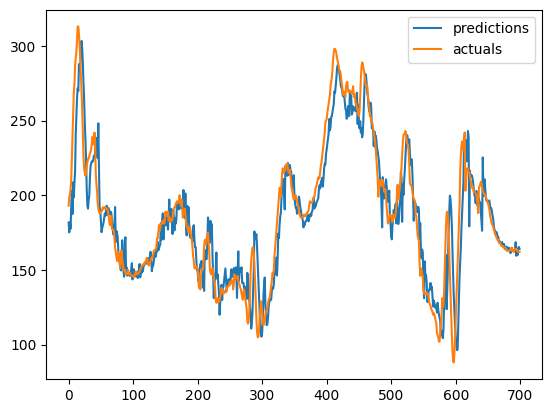

In [90]:
plt.plot(predictions[:700], label = 'predictions')
plt.plot(actuals[:700], label = 'actuals')
plt.legend()

# Testing

In [7]:
def test_model(model, test_step_updated_segments, ph, history, input_size):

    # Prepare for training"
    features_list_test, labels_list_test, raw_glu_list_test = prepare_dataset(test_step_updated_segments, ph, history, input_size) # segments, ph, history
    
    # Build training and validation loader
    features_array_test = np.array(features_list_test)
    labels_array_test = np.array(raw_glu_list_test) # Maybe need to replace this

    X_test, y_test = features_array_test, labels_array_test

    # Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.append(outputs)
            actuals.append(targets)

    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()

    rmse = np.sqrt(mean_squared_error(actuals,predictions))
    print(f'RMSE on validation set: {rmse}')
    
    return predictions, actuals, rmse

In [41]:
# load model from .pth
import os
import glob

ph = 6
history = 6
input_size = 4

# make a directory called eighty_twenty
# save the training and test data in this directory
# os.makedirs('./processed_data/kfold', exist_ok=True)
# model_save_dir = './processed_data/eighty_twenty/training_split_80_20_{ph}_{history}_{input_size}.pkl


model_dirs = glob.glob("./model_checkpoints_kfold_all/model_fold_*.pth")

folder_dir = "./model_checkpoints_kfold_all"

hidden_size = 128  # Hidden vector size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Single output
dropout_prob = 0.2  # Dropout probability

model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob) # input_size, hidden_size, num_layers, output_size, dropout_prob
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# model.load_state_dict(torch.load(model_dir))

results_save_name = 'results_kfold_{ph}_{history}_{input_size}.csv'.format(ph=ph, history=history, input_size=input_size)

results_save_dir = os.path.join(folder_dir, results_save_name)

In [42]:
import glob
import pickle
import torch
import pandas as pd

# Assuming model_dirs is a list of paths to the model state dictionaries

# Initialize lists to store data
data = []

for path in model_dirs: 
    model.load_state_dict(torch.load(path))
    print(path)
    fold_number = path.split('_')[-1].replace('.pth', '')
    print(fold_number)
    for file in glob.glob("./processed_data/*test*shrink.pkl"):
        test_filename = file
        with open(test_filename, 'rb') as f:
            test_loaded_df_dict = pickle.load(f)

        # Verify the content
        test_step_updated_segments = test_loaded_df_dict
        pred, true, rmse = test_model(model, test_step_updated_segments, ph, history, input_size)
        
        fname = file.split('\\')[-1].split('_')[0]
        
        # Append data to the list
        data.append({'fname': fname, 'fold': fold_number, 'rmse': rmse})

# Convert the list of dictionaries to a DataFrame
all_dat = pd.DataFrame(data)

# Pivot the DataFrame

# Display the pivoted DataFrame
print(all_dat)


all_dat = pd.DataFrame(data)

# # Pivot the DataFrame


./model_checkpoints_kfold_all\model_fold_1.pth
1
len of features_list 2393
len of labels_list 2393
RMSE on validation set: 24.065876007080078
len of features_list 2537
len of labels_list 2537
RMSE on validation set: 20.261547088623047
len of features_list 2635
len of labels_list 2635
RMSE on validation set: 23.931198120117188
len of features_list 2480
len of labels_list 2480
RMSE on validation set: 24.04727554321289
len of features_list 2758
len of labels_list 2758
RMSE on validation set: 20.785606384277344
len of features_list 2716
len of labels_list 2716
RMSE on validation set: 22.138957977294922
./model_checkpoints_kfold_all\model_fold_2.pth
2
len of features_list 2393
len of labels_list 2393
RMSE on validation set: 23.394378662109375
len of features_list 2537
len of labels_list 2537
RMSE on validation set: 20.403261184692383
len of features_list 2635
len of labels_list 2635
RMSE on validation set: 24.347885131835938
len of features_list 2480
len of labels_list 2480
RMSE on validati

In [43]:
all_dat = all_dat.pivot(index='fname', columns='fold', values='rmse').reset_index()


In [44]:
import pandas as pd



# Calculate the average RMSE for each fold
average_row = pd.DataFrame({
    'fname': ['average'],
    '1': [all_dat['1'].mean()],
    '2': [all_dat['2'].mean()],
    '3': [all_dat['3'].mean()],
    '4': [all_dat['4'].mean()],
    '5': [all_dat['5'].mean()]
})

# Concatenate the original DataFrame with the average row
all_dat_with_average = pd.concat([all_dat, average_row], ignore_index=True)
all_dat_with_average.set_index('fname', inplace=True),

all_dat_with_average['average'] = all_dat_with_average.mean(axis=1)
# Display the updated DataFrame
all_dat_with_average.to_csv(results_save_dir)
all_dat_with_average

,1,2,3,4,5,average
fname,,,,,,
559,24.065876,23.394379,23.754286,23.850183,20.756035,23.164150
563,20.261547,20.403261,20.331432,20.101543,19.622749,20.144108
570,23.931198,24.347885,25.411955,24.379482,17.499884,23.114082
575,24.047276,24.558891,24.404753,24.087402,25.355108,24.490686
588,20.785606,20.920549,20.780252,20.550097,18.075588,20.222418
591,22.138958,22.132015,22.187702,22.234297,23.010569,22.340710
average,22.538408,22.626162,22.811729,22.533834,20.719990,22.246027


In [45]:
all_dat_with_average
# make fname the index
# all_dat_with_average    
# # get the average of the 5 folds
# all_dat_with_average['average'] = all_dat_with_average.mean(axis=1)



,1,2,3,4,5,average
fname,,,,,,
559,24.065876,23.394379,23.754286,23.850183,20.756035,23.164150
563,20.261547,20.403261,20.331432,20.101543,19.622749,20.144108
570,23.931198,24.347885,25.411955,24.379482,17.499884,23.114082
575,24.047276,24.558891,24.404753,24.087402,25.355108,24.490686
588,20.785606,20.920549,20.780252,20.550097,18.075588,20.222418
591,22.138958,22.132015,22.187702,22.234297,23.010569,22.340710
average,22.538408,22.626162,22.811729,22.533834,20.719990,22.246027


In [ ]:
all_dat_with_average

,1,2,3,4,5,average
fname,,,,,,
559,24.065876,23.394379,23.754286,23.850183,20.756035,23.164150
563,20.261547,20.403261,20.331432,20.101543,19.622749,20.144108
570,23.931198,24.347885,25.411955,24.379482,17.499884,23.114082
575,24.047276,24.558891,24.404753,24.087402,25.355108,24.490686
588,20.785606,20.920549,20.780252,20.550097,18.075588,20.222418
591,22.138958,22.132015,22.187702,22.234297,23.010569,22.340710
average,22.538408,22.626162,22.811729,22.533834,20.719990,22.246027


In [ ]:
# make a 3x 2 plot and plot the preds and actuals of each one in each and have the title be the filename and the rmse

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i in range(3):
    for j in range(2):
        idx = i*2 + j
        axs[i, j].plot(preds[idx], label = 'predictions')
        axs[i, j].plot(trues[idx], label = 'actuals')
        axs[i, j].legend()
        axs[i, j].set_title(f'{fname[idx]} RMSE: {errors[idx]:.4f}')
        
plt.tight_layout()

In [ ]:
# convert this all to a table 
# save the table as a csv
# convert the fname and the rmse to a dataframe
curr_dat = pd.DataFrame({'fname': fname, 'rmse': errors})


In [ ]:
curr_dat.to_csv(f'fold_{fold_num}_sampling_horizon{ph}_ALL.csv', index=False)

In [ ]:
curr_dat

In [ ]:
# import the files with the foldname 
file_dir = "./fold*6.csv"
dirs = glob.glob(file_dir)

In [ ]:
dfs = []
for path in dirs: 
    curr_dat = pd.read_csv(path)
    curr_dat['fold'] = path.split('_')[1]
    dfs.append(curr_dat)
    
all_dat = pd.concat(dfs)

all_dat = all_dat.pivot(index='fname', columns='fold', values='rmse').reset_index()

all_dat

In [ ]:
# print the averages of each column 
# make fname the index"
all_dat.set_index('fname', inplace=True)
all_dat['avg'] = all_dat.mean(axis=1)

In [ ]:
all_dat.to_csv('k_folds_ph_6_ALL.csv')

In [ ]:
all_dat

In [ ]:
# load results of prediction_horizon_6.csv
eighty_20 = pd.read_csv('prediction_horizon_6.csv')
eighty_20